In [1]:
import numpy as np
import networkx as nx
import pandas as pd
import geopandas as gpd
import shapely.geometry
import matplotlib.pyplot as plt
import momepy
import math
import datetime
import time
import simpy
import opentnsim.core as core
import pyproj

C:\Users\gijn\Anaconda3\envs\thesis2\lib\site-packages\geopandas\_compat.py:111: UserWarning: The Shapely GEOS version (3.9.1-CAPI-1.14.2) is incompatible with the GEOS version PyGEOS was compiled with (3.10.4-CAPI-1.16.2). Conversions between both will be slow.
  warnings.warn(


In [2]:
points = {
    'lon':[4.371614106183969, 4.37164219, 4.37172743, 4.371961446987378, 4.371921976441537, 4.37208945, 4.372139628308608, 4.3722095475612415],
    'lat':[52.00176081695087, 52.00179340, 52.00180571, 52.00169833237554, 52.001617796572035, 52.00143929, 52.00148032995194, 52.00146019591659]
}


In [3]:
lon = points['lon']
lat = points['lat']
n_nodes = len(lat)


In [4]:
#df = pd.DataFrame(points)
#geometry = gpd.points_from_xy(df['lon'], df['lat'])
#gdf = gpd.GeoDataFrame(df, geometry = geometry)

#gdf.to_file('Network_exp_3_v2.geojson')

In [5]:
# Create a graph representing the pond
edges = []
nodes = []
# Loop over all the nodes
for i, (lat, lon) in enumerate(zip(lat, lon)):
    start = i
    # Are we at the end node?
    # then we need to close the loop
    if i == (n_nodes - 1):
        node = {
        "lat": lat,
        "lon": lon,
        "n": i,
        "geometry": shapely.geometry.Point(lon, lat),
        }
        nodes.append(node)
        break
    else:
        end = i + 1
        
    # an edge consists of a start node 
    edge = {
        "source": start, 
        "target": end,
        "e": (start, end),
    }
    node = {
        "lat": lat,
        "lon": lon,
        "n": i,
        "geometry": shapely.geometry.Point(lon, lat),
    }
    edges.append(edge)
    nodes.append(node)
edges_df = pd.DataFrame(edges)
nodes_df = pd.DataFrame(nodes)
display(edges_df)
display(nodes_df)

,source,target,e
0,0,1,"(0, 1)"
1,1,2,"(1, 2)"
2,2,3,"(2, 3)"
3,3,4,"(3, 4)"
4,4,5,"(4, 5)"
5,5,6,"(5, 6)"
6,6,7,"(6, 7)"


,lat,lon,n,geometry
0,52.001761,4.371614,0,POINT (4.371614106183969 52.00176081695087)
1,52.001793,4.371642,1,POINT (4.37164219 52.0017934)
2,52.001806,4.371727,2,POINT (4.37172743 52.00180571)
3,52.001698,4.371961,3,POINT (4.371961446987378 52.00169833237554)
4,52.001618,4.371922,4,POINT (4.371921976441537 52.00161779657203)
5,52.001439,4.372089,5,POINT (4.37208945 52.00143929)
6,52.001480,4.372140,6,POINT (4.372139628308608 52.00148032995194)
7,52.001460,4.372210,7,POINT (4.372209547561241 52.00146019591659)


,lat,lon,n,geometry
0,52.001761,4.371614,0,POINT (4.37161 52.00176)
1,52.001793,4.371642,1,POINT (4.37164 52.00179)
2,52.001806,4.371727,2,POINT (4.37173 52.00181)
3,52.001698,4.371961,3,POINT (4.37196 52.00170)
4,52.001618,4.371922,4,POINT (4.37192 52.00162)
5,52.001439,4.372089,5,POINT (4.37209 52.00144)
6,52.001480,4.372140,6,POINT (4.37214 52.00148)
7,52.001460,4.372210,7,POINT (4.37221 52.00146)


<AxesSubplot: >

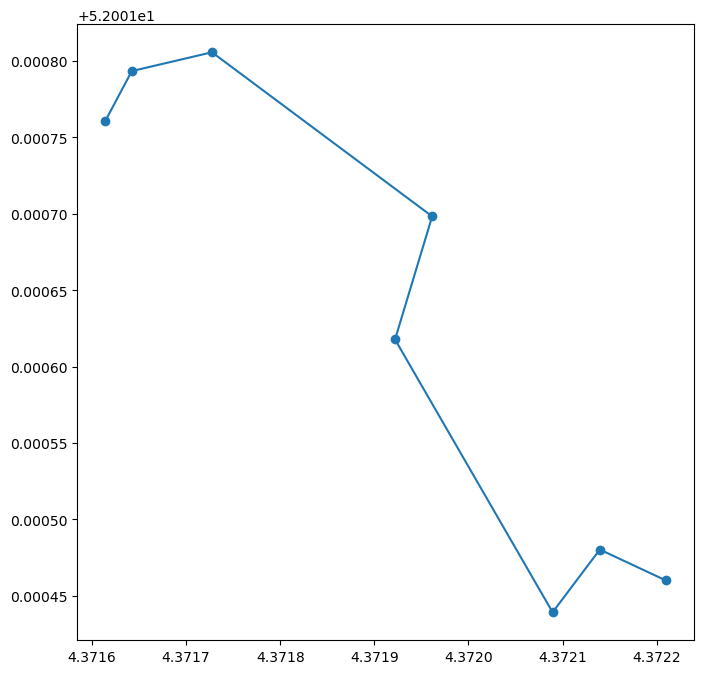

In [6]:
# create two temporary columns with the start end end geometry
edges_df['source_geometry'] = nodes_df['geometry'][edges_df['source']].reset_index(drop=True)
edges_df['target_geometry'] = nodes_df['geometry'][edges_df['target']].reset_index(drop=True)
# for each edge combine start and end geometry into a linestring (line)
edges_df['geometry'] = edges_df.apply(
    lambda row: shapely.geometry.LineString([row['source_geometry'], row['target_geometry']]), 
    axis=1
)
edges_df = edges_df.drop(columns=['source_geometry', 'target_geometry'])

nodes_gdf = gpd.GeoDataFrame(nodes_df)
edges_gdf = gpd.GeoDataFrame(edges_df)

#Used RD (epsg:28992) to define coordinates so set it this way
nodes_gdf = nodes_gdf.set_crs('epsg:4326')
edges_gdf = edges_gdf.set_crs('epsg:4326')


#edges_gdf["length_m"] = edges_gdf["geometry"].apply(lambda geom: geom.length)

display(nodes_gdf)

# This is the spatial figure
fig, ax = plt.subplots(figsize=(13, 8))
edges_gdf.plot(ax=ax)
nodes_gdf.plot(ax=ax)

### Network

In [7]:
# convention is that we call our graph FG (fairway graph)
FG = nx.from_pandas_edgelist(edges_gdf, edge_attr=True)

In [8]:
# update all nodes with info from the nodes table
nodes_gdf.apply(lambda row: FG.nodes[row.n].update(row), axis=1);

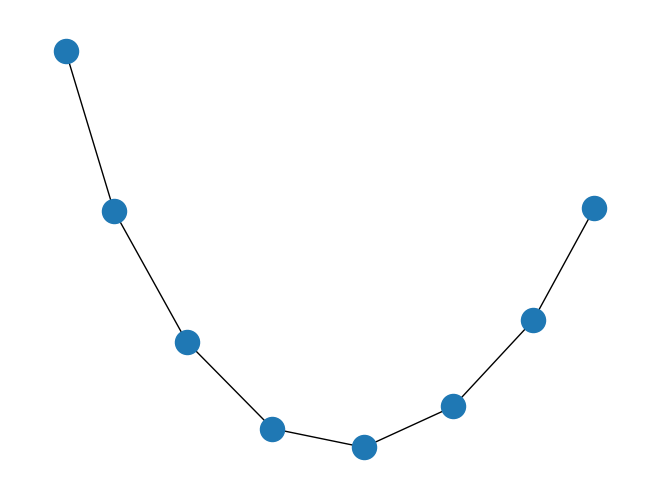

In [9]:
nx.draw(FG)